In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
from sys import platform
import f90nml
from importlib import reload
import sys
sys.path.append('../ice4')
import retrievestuff as rs

ModuleNotFoundError: No module named 'retrievestuff'

In [54]:
%matplotlib notebook

In [55]:
# Have to do this in case of different operating systems
if platform == "linux" or platform == "darwin":
    slash = '/'
else: # This is assumed to be Windows
    slash = '\\'
#print(slash)

In [56]:
# This is the folder name
#foldername = "Fri Mar  1 14_36_55 2019"; filename = "surface.txt"
#foldername = "Fri Mar 29 13_43_02 2019"; filename = "surface.txt"
#foldername = "Case2.0 (calibration)"; filename = "surface_filtered.txt"
foldername = "Case2.1"; filename = "surface_filtered.txt"

# Load a height file (for synthetic data)
#filename = "surface.txt"

sollast = np.loadtxt(foldername+slash+filename)
Ny, Nx = np.shape(sollast); #print(sollast.shape)
Ntot = np.size(sollast)
print("Nx =", Nx)
print("Ny =", Ny)
print('Npts = ', Ntot)

# Get other parameters
params = f90nml.read(foldername+slash+'parameters.nml')
Lx = params['parameters']['Lx']; print("Lx =", Lx)
Ly = params['parameters']['Ly']; print("Ly =", Ly)

Nx = 41
Ny = 43
Npts =  1763
Lx = 22.678572
Ly = 23.245536299999998


In [57]:
# Get the x and y axes as arrays and grids
x = np.linspace(0,Lx,Nx); #print(x[1]-x[0])
y = np.linspace(0,Ly,Ny); 
xgrid,ygrid = np.meshgrid(x,y); #print(xgrid.shape)
dx = x[1]-x[0]
dy = y[1]-y[0]

<IPython.core.display.Javascript object>


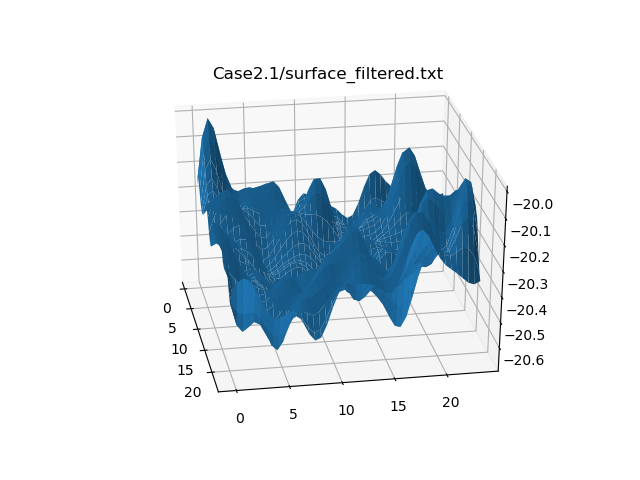

In [58]:
# Plot the surface as a mesh
fig1 = plt.figure()
ax = fig1.add_subplot(111, projection='3d')
ax.plot_surface(xgrid, ygrid, sollast)
ax.set_title(foldername+slash+filename)
ax.view_init(30, -10)

Sturges rule says nbins =  11
Using nbins =  11
Original =  1680
4 0 420 [239  85  45  27   8   8   3   3   1]
4 1 420 [244  98  46  13   8   6   0   3   1]
4 2 420 [233 108  43  21   6   5   1   2   0]
4 3 420 [242  89  45  16  10   6   3   5   1]
ilevelp = 4
ilevelp, t = 4 2.7764451051977987
meanZ2 =  0.008548629819081026
statsigma =  0.09245880065781205


<IPython.core.display.Javascript object>


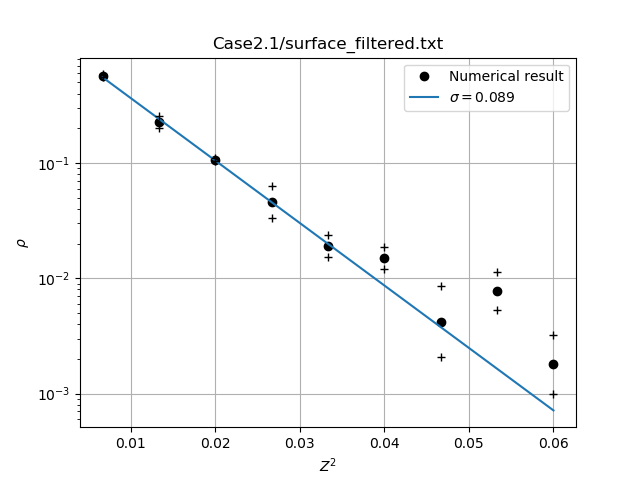

In [60]:
# Get the probability distribution in Z2
nbins_max = 14
nbins_sturges = int(1+3.3*np.log10(Ntot)); print('Sturges rule says nbins = ', nbins_sturges)
nbins = np.min([nbins_max,nbins_sturges]); print('Using nbins = ', nbins)
Z2max = .06
Z2bins = np.linspace(0,Z2max,nbins-1)
counts, bins, meanZ2, error = rs.getrhoofz2(sollast,dx,dy,Z2bins=Z2bins,levels=3)
# print(counts)
# print(error)
print('meanZ2 = ', meanZ2)
print('statsigma = ', np.sqrt(meanZ2))

# Graphing it
fig = plt.figure()
plt.semilogy(bins, counts, 'ok', label='Numerical result')
plt.grid(True)
plt.xlabel('$Z^2$')
plt.ylabel(r'$\rho$')
plt.title(foldername+slash+filename)

# Line fitting
subset = np.array([i for i in range(0,len(bins)-5)])
newbins = bins
logcounts = np.log(counts[subset])
p = np.polyfit(newbins[subset], logcounts, 1)
sigma = 1/(-p[0])**.5
sigma = int(sigma*1000)/1000
plt.semilogy(bins, np.exp(np.polyval(p,bins)), label=r'$\sigma = $'+str(sigma))

# Add a legend
plt.legend()

# Graphing the error bars (sloppily)
countsplus = counts+error
countsminus = counts**2/countsplus
plt.semilogy(bins, countsplus, '+k')
plt.semilogy(bins, countsminus, '+k')
